### This notebook includes fitting the pre-processed data from the Notebook01, applying XGBoost model and discussing the performance.

In [1]:
# Importing necessary libraries
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import numpy as np

#### Loading the pre-processed data from the Notebook01.

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

In [3]:
# Mapping function to convert 'yes' to 1 and 'no' to 0
y_train['y']= y_train['y'].map({'yes': 1, 'no': 0})
y_test['y'] = y_test['y'].map({'yes': 1, 'no': 0})

### Fitting an XGBoost Model

In [4]:
# Create an XGBoost classifier
xgb_model = XGBClassifier()

# Fit the model to the training data
xgb_model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [5]:
# Make predictions on the test data using the trained model
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
# Display the first few predictions
y_pred_xgb[:10], y_pred_xgb_proba[:10]

(array([0, 0, 1, 1, 0, 1, 1, 1, 0, 0]),
 array([2.0341709e-04, 1.3100339e-01, 9.9752349e-01, 9.9388969e-01,
        8.9141558e-06, 9.9967074e-01, 9.4384962e-01, 9.9441862e-01,
        1.7016148e-03, 1.8754549e-02], dtype=float32))

### Measuring the Performance of XGBoost Model

In [7]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print the classification report
class_report = classification_report(y_test, y_pred_xgb)
print("Classification Report:")
print(class_report)

Accuracy: 0.9519487785168148
Confusion Matrix:
[[7578  437]
 [ 336 7736]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      8015
           1       0.95      0.96      0.95      8072

    accuracy                           0.95     16087
   macro avg       0.95      0.95      0.95     16087
weighted avg       0.95      0.95      0.95     16087



/var/folders/12/rnky8q5n4vnb_wvb9wbqcjgm0000gn/T/ipykernel_15278/450706973.py:17: RuntimeWarning: divide by zero encountered in divide
  lift = cum_gains / baseline


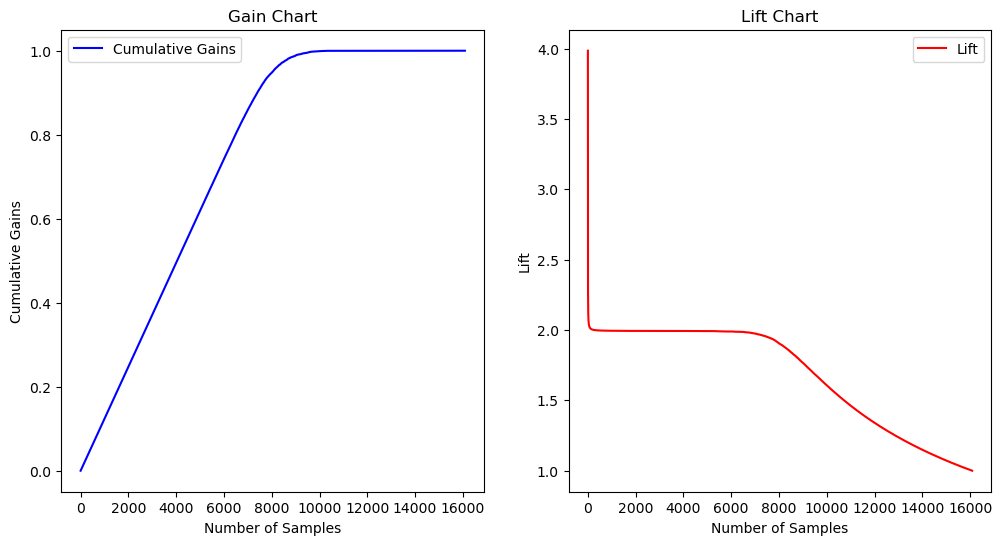

In [8]:
import matplotlib.pyplot as plt

# Function to plot Lift and Gain Charts
def plot_lift_gain_chart(y_true, y_pred_xgb_proba):
    # Convert "yes" and "no" labels to binary labels (1 and 0)
    y_true_binary = y_true.replace({'yes': 1, 'no': 0}).values

    # Sort the probabilities and true labels in descending order
    sorted_indices = np.argsort(y_pred_xgb_proba)[::-1]
    sorted_y_true = y_true_binary[sorted_indices]

    # Calculate the cumulative gains
    cum_gains = np.cumsum(sorted_y_true) / np.sum(sorted_y_true)

    # Calculate the lift values correctly
    baseline = np.linspace(0, 1, len(y_true))
    lift = cum_gains / baseline

    # Plot the Lift and Gain Charts
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(cum_gains, label='Cumulative Gains', color='b')
    plt.xlabel('Number of Samples')
    plt.ylabel('Cumulative Gains')
    plt.title('Gain Chart')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(lift, label='Lift', color='r')
    plt.xlabel('Number of Samples')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.legend()
    plt.show()

# Plot the Lift and Gain Charts
plot_lift_gain_chart(y_test, y_pred_xgb_proba)

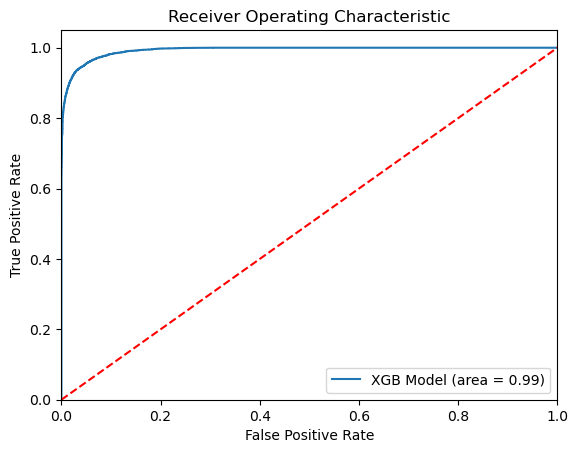

AUC Score:  0.9927382735047703


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

# Convert 'yes' and 'no' labels to binary labels (1 and 0)
y_test_binary = y_test.replace({'yes': 1, 'no': 0}).values

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_xgb_proba)

# Now, you can plot the ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label='XGB Model (area = %0.2f)' % roc_auc_score(y_test_binary, y_pred_xgb_proba))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculating AUC
auc = roc_auc_score(y_test_binary, y_pred_xgb_proba)
print("AUC Score: ", auc)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the XGBoost model
xgb_model = XGBClassifier()

# Define the hyperparameter grid for Randomized Search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Learning rate
    'n_estimators': [100, 200, 300, 400],  # Number of boosting rounds
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of trees
    'min_child_weight': [1, 2, 3, 4],  # Minimum sum of instance weight needed in a child
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees
    'lambda': [0, 0.1, 1, 10],  # L2 regularization term on weights
    'alpha': [0, 0.1, 1, 10]  # L1 regularization term on weights
}

# Create the Randomized Search CV object
random_search_xgb = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_grid, 
    n_iter=100,  # Number of random combinations to try
    scoring='accuracy',  # You can use different scoring metrics
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    verbose=1  # Show progress during the search
)

# Fit the Randomized Search on the training data
random_search_xgb.fit(X_train, y_train.values.ravel())

# Get the best hyperparameters and model
best_params_xgb = random_search_xgb.best_params_
best_model_xgb = random_search_xgb.best_estimator_

# Evaluate the best model on the test data
y_pred_best_xgb = best_model_xgb.predict(X_test)
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)

print(f'Best Hyperparameters (XGBoost - Random Search): {best_params_xgb}')
print(f'Best Model Accuracy (XGBoost - Random Search): {accuracy_best_xgb}')

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the XGBoost model
xgb_model = XGBClassifier()

# Define the hyperparameter grid for Grid Search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Learning rate
    'n_estimators': [100, 200, 300, 400],  # Number of boosting rounds
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of trees
    'min_child_weight': [1, 2, 3, 4],  # Minimum sum of instance weight needed in a child
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees
    'lambda': [0, 0.1, 1, 10],  # L2 regularization term on weights
    'alpha': [0, 0.1, 1, 10]  # L1 regularization term on weights
}

# Create the Grid Search CV object
grid_search_xgb = GridSearchCV(
    xgb_model, 
    param_grid=param_grid, 
    scoring='accuracy',  # You can use different scoring metrics
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    verbose=1  # Show progress during the search
)

# Fit the Grid Search on the training data
grid_search_xgb.fit(X_train, y_train.values.ravel())

# Get the best hyperparameters and model
best_params_xgb_grid = grid_search_xgb.best_params_
best_model_xgb_grid = grid_search_xgb.best_estimator_

# Evaluate the best model on the test data
y_pred_best_xgb_grid = best_model_xgb_grid.predict(X_test)
accuracy_best_xgb_grid = accuracy_score(y_test, y_pred_best_xgb_grid)

print(f'Best Hyperparameters (XGBoost - Grid Search): {best_params_xgb_grid}')
print(f'Best Model Accuracy (XGBoost - Grid Search): {accuracy_best_xgb_grid}')